In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import numpy as np

In [3]:
file_path='/content/drive/MyDrive/Colab Notebooks/Final Project/nvda_2018.csv'

In [4]:
# Load and prepare data
data = pd.read_csv(file_path)
data.columns = [
    "time", "open", "high", "low", "close", "PlotCandle (Open)", "PlotCandle (High)",
    "PlotCandle (Low)", "PlotCandle (Close)", "VWAP", "Upper Band #1", "Lower Band #1",
    "Upper Band #2", "Lower Band #2", "Upper Band #3", "Lower Band #3", "MidLine",
    "ImpulseMACD", "ImpulseHisto", "ImpulseMACDSignal", "RSI", "Regular Bullish Label",
    "Regular Bullish", "Hidden Bullish Label", "Hidden Bullish", "Regular Bearish Label",
    "Regular Bearish", "Hidden Bearish Label", "Hidden Bearish"
]

In [5]:
# Example feature set and target (classification: predicting if price goes up or down)
features = ["open", "high", "low", "close", "VWAP", "RSI"]
target = (data['close'].shift(-1) > data['close']).astype(int)  # 1 if price goes up, 0 otherwise

X = data[features].dropna()
y = target.dropna()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [6]:
# Helper function to evaluate classification models
def evaluate_classification_model(model, X_test_pca, y_test):
    y_pred = model.predict(X_test_pca)
    y_pred_binary = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred_binary)
    report = classification_report(y_test, y_pred_binary)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    return cm, report, fpr, tpr, roc_auc, precision, recall

In [7]:
# Linear Regression
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_pca, y_train)
linear_cm, linear_report, linear_fpr, linear_tpr, linear_roc_auc, linear_precision, linear_recall = evaluate_classification_model(linear_regressor, X_test_pca, y_test)

print("Linear Regression Confusion Matrix:")
print(linear_cm)
print("Linear Regression Classification Report:")
print(linear_report)


Linear Regression Confusion Matrix:
[[  99 1040]
 [ 116 1096]]
Linear Regression Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.09      0.15      1139
           1       0.51      0.90      0.65      1212

    accuracy                           0.51      2351
   macro avg       0.49      0.50      0.40      2351
weighted avg       0.49      0.51      0.41      2351



In [8]:
# Support Vector Machine (SVR)
svm_regressor = SVR()
svm_regressor.fit(X_train_pca, y_train)
svm_cm, svm_report, svm_fpr, svm_tpr, svm_roc_auc, svm_precision, svm_recall = evaluate_classification_model(svm_regressor, X_test_pca, y_test)

print("SVR Confusion Matrix:")
print(svm_cm)
print("SVR Classification Report:")
print(svm_report)

SVR Confusion Matrix:
[[ 157  982]
 [ 200 1012]]
SVR Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.14      0.21      1139
           1       0.51      0.83      0.63      1212

    accuracy                           0.50      2351
   macro avg       0.47      0.49      0.42      2351
weighted avg       0.47      0.50      0.43      2351



In [9]:
# Random Forest
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_pca, y_train)
rf_cm, rf_report, rf_fpr, rf_tpr, rf_roc_auc, rf_precision, rf_recall = evaluate_classification_model(rf_regressor, X_test_pca, y_test)

print("Random Forest Confusion Matrix:")
print(rf_cm)
print("Random Forest Classification Report:")
print(rf_report)

Random Forest Confusion Matrix:
[[554 585]
 [581 631]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      1139
           1       0.52      0.52      0.52      1212

    accuracy                           0.50      2351
   macro avg       0.50      0.50      0.50      2351
weighted avg       0.50      0.50      0.50      2351



In [10]:
# XGBoost
xgb_regressor = XGBRegressor(n_estimators=100, random_state=42)
xgb_regressor.fit(X_train_pca, y_train)
xgb_cm, xgb_report, xgb_fpr, xgb_tpr, xgb_roc_auc, xgb_precision, xgb_recall = evaluate_classification_model(xgb_regressor, X_test_pca, y_test)

print("XGBoost Confusion Matrix:")
print(xgb_cm)
print("XGBoost Classification Report:")
print(xgb_report)

XGBoost Confusion Matrix:
[[512 627]
 [539 673]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.45      0.47      1139
           1       0.52      0.56      0.54      1212

    accuracy                           0.50      2351
   macro avg       0.50      0.50      0.50      2351
weighted avg       0.50      0.50      0.50      2351



In [11]:
# Deep Learning Model (Feedforward Neural Network)
ffnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
ffnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ffnn_model.fit(X_train_pca, y_train, epochs=10, batch_size=32, validation_split=0.2)

ffnn_pred = ffnn_model.predict(X_test_pca)
ffnn_pred_binary = (ffnn_pred > 0.5).astype(int)
ffnn_cm = confusion_matrix(y_test, ffnn_pred_binary)
ffnn_report = classification_report(y_test, ffnn_pred_binary)
ffnn_fpr, ffnn_tpr, _ = roc_curve(y_test, ffnn_pred)
ffnn_roc_auc = auc(ffnn_fpr, ffnn_tpr)
ffnn_precision, ffnn_recall, _ = precision_recall_curve(y_test, ffnn_pred)
ffnn_pred = ffnn_model.predict(X_test_pca)
ffnn_pred_binary = (ffnn_pred > 0.5).astype(int)
ffnn_cm = confusion_matrix(y_test, ffnn_pred_binary)
ffnn_report = classification_report(y_test, ffnn_pred_binary)

print("FFNN Confusion Matrix:")
print(ffnn_cm)
print("FFNN Classification Report:")
print(ffnn_report)

Epoch 1/10
235/235 [==============================] - 6s 18ms/step - loss: 0.6963 - accuracy: 0.4936 - val_loss: 0.6944 - val_accuracy: 0.5005
Epoch 2/10
235/235 [==============================] - 3s 13ms/step - loss: 0.6943 - accuracy: 0.5076 - val_loss: 0.6937 - val_accuracy: 0.5064
Epoch 3/10
235/235 [==============================] - 2s 8ms/step - loss: 0.6938 - accuracy: 0.5125 - val_loss: 0.6926 - val_accuracy: 0.5069
Epoch 4/10
235/235 [==============================] - 2s 9ms/step - loss: 0.6934 - accuracy: 0.5158 - val_loss: 0.6925 - val_accuracy: 0.5064
Epoch 5/10
235/235 [==============================] - 1s 6ms/step - loss: 0.6935 - accuracy: 0.5048 - val_loss: 0.6919 - val_accuracy: 0.5170
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.6935 - accuracy: 0.5085 - val_loss: 0.6932 - val_accuracy: 0.5021
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 0.5136 - val_loss: 0.6924 - val_accuracy: 0.5101
Epoc

In [12]:
# LSTM (for sequential data)
X_train_seq = X_train_pca.reshape((X_train_pca.shape[0], 1, X_train_pca.shape[1]))
X_test_seq = X_test_pca.reshape((X_test_pca.shape[0], 1, X_test_pca.shape[1]))

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_seq, y_train, epochs=10, batch_size=32, validation_split=0.2)

lstm_pred = lstm_model.predict(X_test_seq)
lstm_pred_binary = (lstm_pred > 0.5).astype(int)
lstm_cm = confusion_matrix(y_test, lstm_pred_binary)
lstm_report = classification_report(y_test, lstm_pred_binary)
lstm_fpr, lstm_tpr, _ = roc_curve(y_test, lstm_pred)
lstm_roc_auc = auc(lstm_fpr, lstm_tpr)
lstm_precision, lstm_recall, _ = precision_recall_curve(y_test, lstm_pred)

print("LSTM Confusion Matrix:")
print(lstm_cm)
print("LSTM Classification Report:")
print(lstm_report)


Epoch 1/10
235/235 [==============================] - 17s 20ms/step - loss: 0.6930 - accuracy: 0.5080 - val_loss: 0.6925 - val_accuracy: 0.5096
Epoch 2/10
235/235 [==============================] - 2s 8ms/step - loss: 0.6928 - accuracy: 0.5144 - val_loss: 0.6924 - val_accuracy: 0.5096
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.6927 - accuracy: 0.5132 - val_loss: 0.6923 - val_accuracy: 0.5090
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.6926 - accuracy: 0.5146 - val_loss: 0.6922 - val_accuracy: 0.5165
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 0.6926 - accuracy: 0.5137 - val_loss: 0.6924 - val_accuracy: 0.5096
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.6926 - accuracy: 0.5160 - val_loss: 0.6924 - val_accuracy: 0.5096
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.6925 - accuracy: 0.5156 - val_loss: 0.6924 - val_accuracy: 0.5096
Epoc

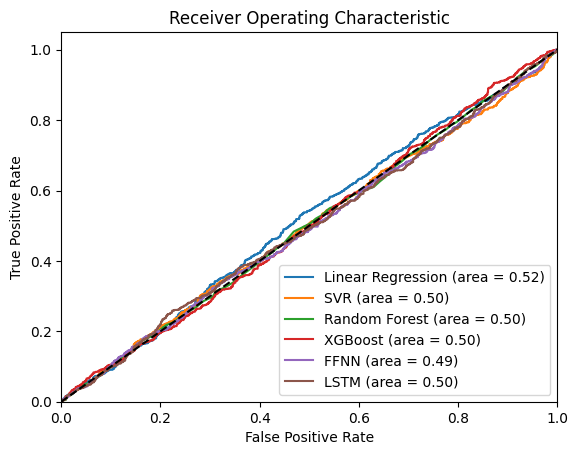

In [13]:
# Plot ROC Curves
plt.figure()
plt.plot(linear_fpr, linear_tpr, label='Linear Regression (area = %0.2f)' % linear_roc_auc)
plt.plot(svm_fpr, svm_tpr, label='SVR (area = %0.2f)' % svm_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost (area = %0.2f)' % xgb_roc_auc)
plt.plot(ffnn_fpr, ffnn_tpr, label='FFNN (area = %0.2f)' % ffnn_roc_auc)
plt.plot(lstm_fpr, lstm_tpr, label='LSTM (area = %0.2f)' % lstm_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

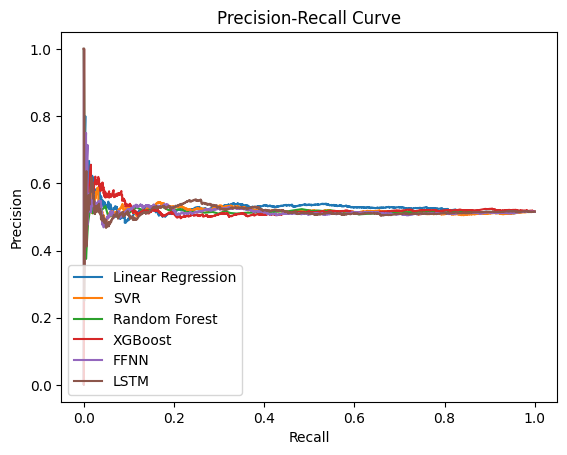

In [14]:
# Plot Precision-Recall Curves
plt.figure()
plt.plot(linear_recall, linear_precision, label='Linear Regression')
plt.plot(svm_recall, svm_precision, label='SVR')
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.plot(xgb_recall, xgb_precision, label='XGBoost')
plt.plot(ffnn_recall, ffnn_precision, label='FFNN')
plt.plot(lstm_recall, lstm_precision, label='LSTM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [15]:
# Print Classification Reports
print("Linear Regression Classification Report:")
print(linear_report)
print("SVR Classification Report:")
print(svm_report)
print("Random Forest Classification Report:")
print(rf_report)
print("XGBoost Classification Report:")
print(xgb_report)
print("FFNN Classification Report:")
print(ffnn_report)
print("LSTM Classification Report:")
print(lstm_report)

Linear Regression Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.09      0.15      1139
           1       0.51      0.90      0.65      1212

    accuracy                           0.51      2351
   macro avg       0.49      0.50      0.40      2351
weighted avg       0.49      0.51      0.41      2351

SVR Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.14      0.21      1139
           1       0.51      0.83      0.63      1212

    accuracy                           0.50      2351
   macro avg       0.47      0.49      0.42      2351
weighted avg       0.47      0.50      0.43      2351

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      1139
           1       0.52      0.52      0.52      1212

    accuracy                           0.50      2351
   macro avg       0.50